# <center> École des Ponts ParisTech</center>
## <center> SPH pour l'hydraulique </center>
### <center> Projet SPH GMM 2021</center>
#### <center> Parois mobiles  </center>
<center> Ruben Persicot & Yohan Lanier </center>


<center> Encadrants : Rémi Carmigniani et Damien Violeau </center>

Ce projet fait partie du cours Smoothed Particle Hydrodynamics. L'objectif est de réaliser des simulations numériques à l'aide de cette méthode tout en intégrant des parois mobiles. Pour ce faire, on utilise l'article "Nonlinear water wave interaction with floating bodies in SPH" de B.Bouscasse et al disponible dans le dossier.

Les objectifs fixés sont présentés ci-dessous et sont de difficulté croissante. 

-1 : Etude d'un l'écoulement de couette plan.

-2 : Etude d'un écoulement dans une cavité entrainée

-3 : Etude d'un écoulement suite à la chute d'un solide.

## 1. Ecoulement de couette plan.

### 1.1 Etude analytique 

### 1.2 Etude numérique 

On commence par importer les différents fichiers utiles pour implémenter le solveur SPH

In [11]:
%load_ext autoreload
%autoreload 2
import numpy as np
from sys import exit
import os.path
from os import path
import csv
import time
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.rcParams['text.usetex'] = True
from src.spyh import *
from src.sphvar import *
from src.plotParticles import *
from src.state import *
from src.contrib import *
from src.analytical_solutions import *
import numba 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
#COUETTE PARAMETERS
e = 0.5 #half width in meters
U = 1 # Upper bound velocity
Re = 1 # Reynolds number
#FLUID PARAMETERS
rhoF = 1000
mu = rhoF*U*e/Re #(Pa.s)
grav = np.array([0.0,0.0])#np.array([0.0,-9.81])#np.array([0.0,0.0]) #m.s-2#OTHER FLUID PARAMETERS
c0 = 10*U
gamma = 7
B = rhoF*c0**2/gamma 
#DENSITY & SHEPARD THRESHOLDS : 
shepardMin = 10**(-6)
rhoMin = 0.5*rhoF
rhoMax = 1.5*rhoF

In [3]:
#PARTICLES & SPACES PARAMETERS : 
N = 4
dr = 2*e/(4*N)
h = smthfc*dr
m=dr*dr*rhoF
lspace = 2*h
#COMPUTATION DOMAIN : 
xOrigin = 0
yOrigin = -e-nBound*dr
xSize = 4*lspace
ySize = 2*e+2*nBound*dr
xMax = xOrigin+xSize
yMax = yOrigin+ySize

Les FLAGs sont définis dans le fichier [src/sphvar.py](src/sphvar.py)

Les murs seront composés d'une couche de *nBound =4* particules *fictives*. Ce nombre est suffisant pour éviter la pénétration du mur.

In [4]:
#INIT PART:
part = init_particles()
part = addBox(part,[0,-e,4*lspace,2*e],FLUID,dr,rhoF)
part = addBox(part,[0,-e-nBound*dr,4*lspace,nBound*dr],BOUND,dr,rhoF)
part = addBox(part,[0,e,4*lspace,nBound*dr],MOBILEBOUND,dr,rhoF)
#PERIODICITY VECTOR
vecPer = np.array([4*lspace,0])
posSpace,neibSpace,partSpace,listNeibSpace = init_spaces(xOrigin,yOrigin,xSize,ySize,lspace,dr,vecPer)
part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)

In [5]:
len(part)

384

<IPython.core.display.Javascript object>


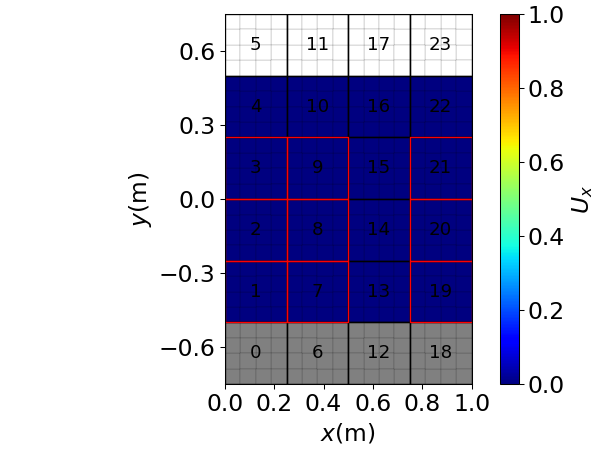

In [6]:
%matplotlib notebook
Umax= 1
tabUx = part[:,VEL[0]]
domain = [xOrigin,xMax,yOrigin,yMax,0,Umax]
plotPropertiesWithBound(part,tabUx,r'$U_x$',domain,dr,1)

In [7]:
plotSpaces(posSpace,'k',lspace,1)
neibSpace[2][neibSpace[2]>-1]
spacesOutline(posSpace[neibSpace[2][neibSpace[2]>-1]],'r',lspace,1)

In [8]:
f = plt.figure(1)
figName = 'Figures/periodic.pdf'
f.savefig(figName,bbox_inches='tight')

In [9]:
part[:,VEL] = initMobileBoundVelocity((part[:,INFO]==MOBILEBOUND), part[:,VEL], U)
part[:,RHO],part[:,VEL] =interpolateBoundaryPeriodicX((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)

LoweringError: Failed in nopython mode pipeline (step: nopython mode backend)
[1m[1mnon-numeric type in Num
[1m
File "src\spyh.py", line 363:[0m
[1mdef interpolateBoundaryPeriodicX(partBOUND,partSPID,partPos,partVel,partRho,listNeibSpace,\
    <source elided>
                # keep only the fluid particles 
[1m                listnb = listnb[partBOUND[listnb]==False]
[0m                [1m^[0m[0m
[0m
[0m[1mDuring: lowering "$98compare_op.29 = arrayexpr(expr=(<built-in function eq>, [Var($94binary_subscr.27, spyh.py:363), const(bool, False)]), ty=array(bool, 1d, C))" at C:\Users\persi\OneDrive\Documents\GitHub\SPH_Projet\src\spyh.py (363)[0m

In [ ]:
current_directory = os.getcwd()
case_directory = os.path.join(current_directory, r'Results/Couette_'+time.strftime("%Y%m%d_%H%M%S"))
os.mkdir(case_directory)
data_directory = os.path.join(case_directory,r'Data')
figures_directory = os.path.join(case_directory,r'Figures')
os.mkdir(data_directory)
os.mkdir(figures_directory)

In [ ]:
# Here we specify the output frequencies
dt_figure = 0.025*e**2*rhoF/mu
t_print = 0
#final time :
t_end = 3
t=0
it=0
im_count=0
ytab = np.linspace(-1,1,100)
#timetab = np.linspace(0,5,60)
#tau = 2*e/U
#Uan_with_time = analyticalCouetteFlow(0,U,e,timetab*rhoF/mu*e**2/tau)
Utab = (U/2)*(ytab/(2*e) + 1)
timeTabU = np.empty((0,2),float)
print(Utab)

In [ ]:
%matplotlib notebook
while t<t_end:
    #STEP1 : Calcul de la CFL
    dt = CFLConditions(part[:,VEL],h,c0,grav,rhoF,mu)
    #STEP2 : Interpolation des conditions au bord
    part[:,RHO],part[:,VEL] =interpolateBoundaryPeriodicX((part[:,INFO]==BOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)
    #STEP2BIS : Interpolation des conditions au bord sur les mobiles bound
    part[:,RHO], part[:, VEL] = interpolateMobileBoundaryPeriodicX((part[:,INFO]==MOBILEBOUND),\
                                     part[:,SPID],\
                                     part[:,POS],\
                                     part[:,VEL],\
                                     np.array([U, 0.0]),\
                                     part[:,RHO],\
                                     listNeibSpace,\
                                 aW,h,m,B,rhoF,gamma,grav,vecPer[0],shepardMin)
    
    #STEP3 : Calcul des forces et des termes de densité
    part[:,FORCES],part[:,DRHODT] = computeForcesMorrisPeriodicX((part[:,INFO]==FLUID),\
                                                 part[:,SPID],\
                                                 part[:,POS],\
                                                 part[:,VEL],\
                                                 part[:,RHO],\
                                                 listNeibSpace,\
                                                 aW,h,m,B,rhoF,gamma,grav,mu,vecPer[0])
    #STEP4 : Integration en temps
    part[:,POS],part[:,VEL],part[:,RHO] = integrationStepPeriodicX((part[:,INFO]==FLUID),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt,vecPer[0])
    #STEP4BIS : integration en temps des particules de la paroi mobile
    part[:,POS], part[:,RHO] = integrationStepPeriodicX_Moving_Bound((part[:,INFO]==MOBILEBOUND),\
                                                       part[:,POS],\
                                                       part[:,VEL],\
                                                       part[:,RHO],\
                                                       part[:,FORCES],\
                                                       part[:,DRHODT],\
                                                       dt,vecPer[0])
    
    #STEP5 : Corriger densité trop basse
    part[:,RHO] = checkDensity(part[:,RHO],rhoMin,rhoMax)
    #STEP6 : Mise à jour des voisins (pas forcément à tous les pas de temps)
    part,partSpace = sortPart(part,posSpace,partSpace,xOrigin,yOrigin,xSize,ySize,lspace,dr)
    listNeibSpace= getListNeib(partSpace,neibSpace,listNeibSpace)
    t +=dt
    it +=1
    if t>=t_print:
        fig = plt.figure(1)
        plt.clf()
        plt.title(r'$t\nu/e^2 = %2.2f$'%(t*mu/rhoF/e**2))
        velMagn = (part[:,VEL[0]]*part[:,VEL[0]]+part[:,VEL[1]]*part[:,VEL[1]])**.5
        domain = [xOrigin,xMax,yOrigin,yMax,0,1]
        plotPropertiesWithBound(part,velMagn,r'$u/U_0$',domain,dr,1)
        figname = os.path.join(figures_directory,r'vel_%06d.png'%im_count)
        fig.savefig(figname,bbox_inches='tight')
        fig.canvas.draw()
        plt.pause(0.01)
        
        #FIGURE DISPLAY
        fig2 = plt.figure(2)
        plt.clf()
        plt.plot(part[:,POS[1]]/e,part[:,VEL[0]]/U,'bo',label=r'$U_x$ SPH')
        plt.plot(part[:,POS[1]]/e,part[:,VEL[1]]/U,'ro',label=r'$U_y$ SPH')
        plt.plot(ytab,Utab,'--k',label=r'Asymptotic')
        #uan = analyticalCouetteFlow(ytab,U,e,timetab*rhoF/mu*e**2/tau)
        #plt.plot(ytab,uan,'--r',label='Analytical')
        plt.xlabel('$z/e$',fontsize=18)
        plt.ylabel('$u/U_0$',fontsize=18)
        plt.xlim(-1-nBound*dr/e,1+nBound*dr/e)
        plt.ylim(-0.2,1.2) 
        plt.legend(loc='upper left')
        plt.tight_layout()
        ax = plt.gca()
        ax.tick_params(axis = 'both', which = 'major', labelsize = 18)
        ax.xaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        plt.tight_layout()
        plt.show(block=False)
        plt.draw()
        figname = os.path.join(figures_directory,r'UV_%06d.png'%im_count)
        fig2.savefig(figname,bbox_inches='tight')
        fig2.canvas.draw()
        plt.pause(0.01)
        im_count = im_count+1
        t_print +=dt_figure
        

### 1.3 Analyse des résultats